In [ ]:
# # this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [ ]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import Delaunay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from scipy import linalg
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.decomposition import PCA

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [ ]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [ ]:
# this is the correct vectorized version
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)

In [ ]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

In [ ]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

# Learning Objectives

-  How to efficiently compute all the pairwise distances among different observations.
- How to use the weights with the distances.
- Test the locally weighted regressors.
- We want to see how to boost their performance; this means boosting, such as gradient boosting.

In [ ]:
# real data application includes cars.csv, concrete.csv and more
data = pd.read_csv('drive/MyDrive/Data Sets/cars.csv')

In [ ]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [ ]:
x = data.drop(columns=['MPG']).values
y = data['MPG'].values

## Compute all pairwise distances efficiently

This means we build a general case, assuming two matrices, we want to compute all the pairwise distances between the rows of matrix 1 and the rows of matrix 2.

In [ ]:
# we want the Euclidean distance
u = np.array(np.random.uniform(2,5,5))
v = np.array(np.random.uniform(1,2,5))

In [ ]:
u

array([3.11739825, 4.88848224, 3.29316218, 2.88324214, 3.02431272])

In [ ]:
v

array([1.33246486, 1.57575096, 1.71185006, 1.37392515, 1.90510822])


$$\large \text{dist}\left(\vec{u},\vec{v}\right):= \sqrt{\sum(u_i-v_i)^2}$$

In [ ]:
np.sqrt(np.sum((u-v)**2))

4.493481972090788

In [ ]:
# what happens if u is matrix that has n rows and 5 columns?
u = np.random.uniform(2,5,(10,5))

In [ ]:
# check the shape
u.shape

(10, 5)

In [ ]:
v.shape # this may create a problem

(5,)

In [ ]:
# let's show a simple code
def dist(u,v):
  return np.sqrt(np.sum((u-v)**2,axis=1))

In [ ]:
dist(u,v)

array([4.28831296, 4.00575339, 5.62032324, 5.3093832 , 4.4798848 ,
       5.55294533, 4.82613811, 4.80947072, 4.82808324, 4.16231254])

In [ ]:
# how about the case when v is a matrix with 5 columns?
def dist(u,v):
  D = []
  if len(v.shape)==1:
    v = v.reshape(1,-1)
  # we would like all the pairwise combinations if u and v are matrices
  # we could avoid two for loops if we consider broadcasting
  for rowj in v:
    D.append(np.sqrt(np.sum((u-rowj)**2,axis=1)))
  return np.array(D).T

In [ ]:
dist(u,v)

array([[4.28831296, 4.00575339, 5.62032324, 5.3093832 , 4.4798848 ,
        5.55294533, 4.82613811, 4.80947072, 4.82808324, 4.16231254]])

In [ ]:
v = np.random.uniform(1,2,(20,5))

In [ ]:
D = dist(u,v)

In [ ]:
D.shape

(10, 20)

In [ ]:
D

array([[4.34425678, 4.39002234, 4.65859935, 4.68886774, 4.64099   ,
        4.10836079, 3.8516475 , 4.46624481, 4.63096529, 4.12261168,
        4.68204756, 4.45579403, 4.52245258, 4.69293154, 4.51745849,
        4.68398539, 4.15873783, 4.20708627, 4.99788228, 4.12717817],
       [4.14314325, 4.14149829, 4.0058683 , 4.19985548, 4.22514908,
        3.67146567, 3.5899247 , 4.19414238, 4.32546104, 4.07018172,
        4.2381748 , 3.95946516, 3.99765945, 4.52051303, 4.18795029,
        4.32116993, 4.09976548, 4.00066191, 4.59082572, 3.94902733],
       [5.60976866, 5.77332143, 5.58459429, 5.95814152, 5.65634027,
        5.5085904 , 5.11003692, 5.74817857, 5.74099237, 5.57201478,
        6.07124447, 5.40600566, 5.55331412, 6.01619952, 5.70655521,
        5.71051656, 5.47360456, 5.56069375, 6.08391667, 5.50611746],
       [5.43232078, 5.71014001, 5.57439343, 5.68129106, 5.53163233,
        5.30181574, 4.91952869, 5.59588946, 5.61242799, 5.1368552 ,
        5.80081162, 5.47425035, 5.34387498, 5

In [ ]:
def weight_function(u,v,kern=Gaussian,tau=0.5):
    return kern(dist(u,v)/(2*tau))

In [ ]:
W = weight_function(u,v,kern=Tricubic,tau=1.7)

In [ ]:
# we show now the effect of scaling onto the data
scale = MinMaxScaler()
uscaled = scale.fit_transform(u)
vscaled = scale.fit_transform(v)

In [ ]:
W = weight_function(uscaled,vscaled,kern=Tricubic,tau=0.35)

In [ ]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau

    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_
        lm = linear_model.Ridge(alpha=0.001)
        w = weight_function(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w)@(x.reshape(-1,1)),np.diag(w)@(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[:,i])@x,np.diag(w[:,i])@y)
            yest_test[i] = lm.predict(x_new[i].reshape(1,-1))
        return yest_test

In [ ]:
model = Lowess(kernel=Epanechnikov,tau=0.02)

In [ ]:
xscaled = scale.fit_transform(x)

In [ ]:
model.fit(xscaled,y)

In [ ]:
yhat = model.predict(xscaled)

In [ ]:
mse(yhat,y)

9.608473561664933

In [ ]:
# we can try the "elbow" approach for tunning tau
taus = np.arange(0.01,0.25,0.01)

In [ ]:
mse_list = []
for tau in taus:
  model = Lowess(kernel=Epanechnikov,tau=tau)
  model.fit(xscaled,y)
  yhat = model.predict(xscaled)
  mse_list.append(mse(yhat,y))

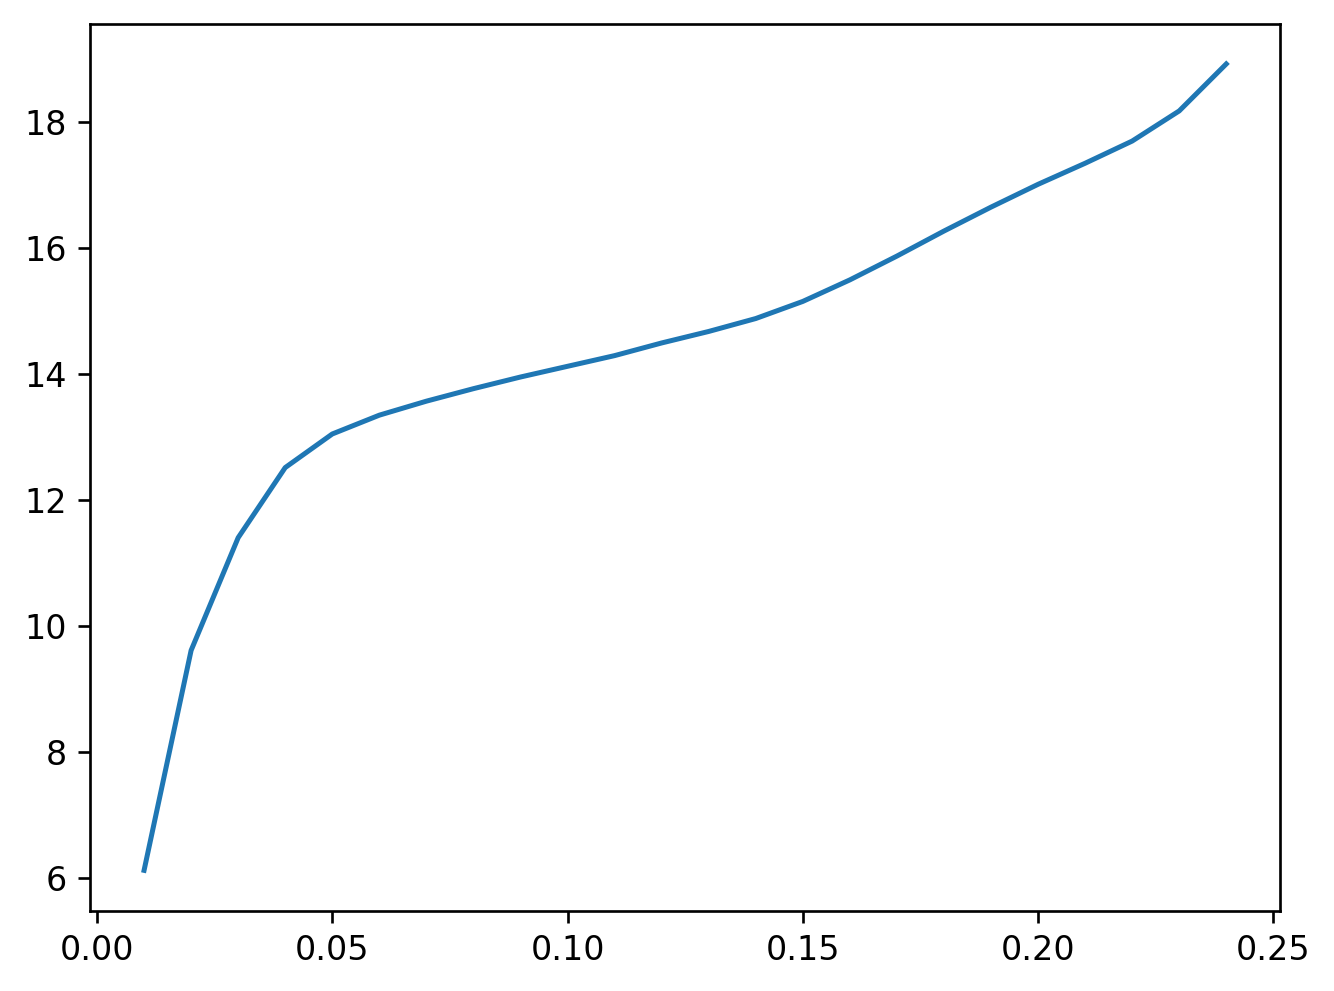

In [ ]:
plt.plot(taus,mse_list)

In [ ]:
mse_lwr = []
mse_rf = []
kf = KFold(n_splits=10,shuffle=True,random_state=1234)
model_rf = RandomForestRegressor(n_estimators=200,max_depth=7)
# model_lw = Lowess_AG_MD(f=1/3,iter=2,intercept=True)
model_lw = Lowess(kernel= Epanechnikov,tau=0.14)

for idxtrain, idxtest in kf.split(x):
  xtrain = x[idxtrain]
  ytrain = y[idxtrain]
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtrain = scale.fit_transform(xtrain)
  xtest = scale.transform(xtest)

  model_lw.fit(xtrain,ytrain)
  yhat_lw = model_lw.predict(xtest)

  model_rf.fit(xtrain,ytrain)
  yhat_rf = model_rf.predict(xtest)

  mse_lwr.append(mse(ytest,yhat_lw))
  mse_rf.append(mse(ytest,yhat_rf))
print('The Cross-validated Mean Squared Error for Locally Weighted Regression is : '+str(np.mean(mse_lwr)))
print('The Cross-validated Mean Squared Error for Random Forest is : '+str(np.mean(mse_rf)))

The Cross-validated Mean Squared Error for Locally Weighted Regression is : 16.455751824170868
The Cross-validated Mean Squared Error for Random Forest is : 17.678888857376226


## Efficient Classes for Computing all the Pairwise Distances

### Scipy Classes

In [ ]:
from scipy.spatial.distance import cdist




# Compute pairwise distances using Euclidean distance metric
pairwise_distances = cdist(xtrain, xtest, metric='euclidean')

print("Pairwise distances:")
print(pairwise_distances)

Pairwise distances:
[[0.02176528 0.97589949 1.07465667 ... 1.03367484 1.01079351 0.43947887]
 [0.14026861 1.04976726 1.15993053 ... 1.11468563 1.08905696 0.49942492]
 [0.03618592 0.98196775 1.08333189 ... 1.04113141 1.01752722 0.44213376]
 ...
 [0.96796902 0.0156773  0.15794466 ... 0.09154571 0.05475171 0.55698237]
 [0.95897078 0.11560343 0.19009382 ... 0.14837735 0.13319966 0.55417906]
 [0.95406098 0.14144446 0.21195662 ... 0.17423515 0.1604333  0.55106959]]


## Faiss

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 40.9 MB/s eta 0:00:00


In [ ]:
import faiss

In [ ]:
# Example vectors
vector1 = xtrain
vector2 = xtest

# Concatenate the vectors into a single array
all_vectors = np.concatenate((vector1, vector2), axis=0)

# Initialize Faiss index
d = all_vectors.shape[1]  # Dimension of vectors
index = faiss.IndexFlatL2(d)  # L2 distance (Euclidean distance)

# Add vectors to the index
index.add(all_vectors)

# Query for the nearest neighbors (in this case, excluding the vector itself)
k = all_vectors.shape[0] - 1  # Return distances to all other vectors
D, I = index.search(all_vectors, k)

# The first row of D corresponds to distances from vector1 to all vectors,
# and the second row corresponds to distances from vector2 to all vectors
pairwise_distances = D[1]

print("Pairwise distances:")
print(pairwise_distances)

Pairwise distances:
[0.00000000e+00 6.89029694e-05 8.41617584e-05 1.24669075e-03
 2.01201439e-03 3.51595879e-03 5.63931465e-03 5.67364693e-03
 6.98184967e-03 7.14087486e-03 7.15255737e-03 7.41600990e-03
 8.37707520e-03 8.65793228e-03 1.06999874e-02 1.07526779e-02
 1.18432045e-02 1.22568607e-02 1.24166012e-02 1.27058029e-02
 1.35922432e-02 1.39296055e-02 1.41646862e-02 1.41646862e-02
 1.52766705e-02 1.52938366e-02 1.54678822e-02 1.56049728e-02
 1.63900852e-02 1.66249275e-02 1.70717239e-02 1.73778534e-02
 1.74448490e-02 1.79543495e-02 1.82802677e-02 1.89366341e-02
 1.91261768e-02 1.94141865e-02 1.96754932e-02 2.00660229e-02
 2.01635361e-02 2.02689171e-02 2.18474865e-02 2.23650932e-02
 2.28676796e-02 2.32322216e-02 2.53779888e-02 2.58045197e-02
 2.71050930e-02 2.76982784e-02 3.11198235e-02 3.18522453e-02
 3.38265896e-02 3.49245071e-02 3.58791351e-02 3.65049839e-02
 3.68406773e-02 3.79137993e-02 3.87270451e-02 3.94816399e-02
 4.02293205e-02 4.47731018e-02 4.50217724e-02 4.51204777e-02
 4.5